## Import libaries

In [0]:
import pandas as pd
import numpy as np 
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.metrics import f1_score

## Import data

In [0]:
# Read from url - Take time to run
url = "http://stat-computing.org/dataexpo/2009/2008.csv.bz2"
df = pd.read_csv(url, compression='bz2')

# Read from drive
#df = pd.read_csv('./temp/Airline.csv')

In [0]:
# Reduce rows
df = df.sample(frac=0.25)

In [6]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
3876048,2008,7,4,5,1142.0,1145,1249.0,1301,US,1711,N948UW,67.0,76.0,48.0,-12.0,-3.0,CLT,ORF,290,3.0,16.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4417116,2008,8,8,5,1029.0,949,1022.0,958,OO,6036,N412SW,53.0,69.0,42.0,24.0,40.0,TVC,ORD,224,3.0,8.0,0,NaN,0,0.0,0.0,0.0,0.0,24.0
4320833,2008,8,29,5,1548.0,1550,1657.0,1630,WN,319,N694SW,129.0,100.0,83.0,27.0,-2.0,DAL,ELP,562,4.0,42.0,0,NaN,0,0.0,0.0,27.0,0.0,0.0
5293470,2008,9,9,2,2041.0,2035,2332.0,2325,AA,1226,N5BUAA,171.0,170.0,140.0,7.0,6.0,MIA,LGA,1097,4.0,27.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3899078,2008,7,22,2,619.0,625,758.0,813,US,1093,N440US,99.0,108.0,75.0,-15.0,-6.0,EWR,CLT,529,15.0,9.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


Variable descriptions: http://stat-computing.org/dataexpo/2009/the-data.html

Reference: https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial

## Data pre-processing

In [7]:
df.count()

Year                 1752432
Month                1752432
DayofMonth           1752432
DayOfWeek            1752432
DepTime              1718129
CRSDepTime           1752432
ArrTime              1714325
CRSArrTime           1752432
UniqueCarrier        1752432
FlightNum            1752432
TailNum              1731352
ActualElapsedTime    1713565
CRSElapsedTime       1752237
AirTime              1713565
ArrDelay             1713565
DepDelay             1718129
Origin               1752432
Dest                 1752432
Distance             1752432
TaxiIn               1714325
TaxiOut              1717938
Cancelled            1752432
CancellationCode       34598
Diverted             1752432
CarrierDelay          381508
WeatherDelay          381508
NASDelay              381508
SecurityDelay         381508
LateAircraftDelay     381508
dtype: int64

In [8]:
#Create Date column
#df['Date'] = pd.to_datetime(df[['Year', 'Month', 'DayofMonth']])

# Drop columns
# Year: The dataset only contains data in 2008
# Cancelled + CancellationCode + Diverted: Cancelled flight does not have delay label.
df.drop(['Year', 'Cancelled', 'CancellationCode', 'Diverted'], axis=1, inplace=True)
# Delay details: Only 20% rows have these features.
df.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1, inplace=True)
# Time: Only keep CRSArrTime, CRSElapsedTime
df.drop(['DepTime', 'ArrTime', 'CRSDepTime', 'ActualElapsedTime', 'DepDelay'], axis=1, inplace=True)
# Airport: Only keep the Dest Airport
df.drop(['Origin'], axis=1, inplace=True)
# Carrier: Drop FlightNum and TailNum
df.drop(['FlightNum', 'TailNum'], axis=1, inplace=True)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.count()

Month             1713564
DayofMonth        1713564
DayOfWeek         1713564
CRSArrTime        1713564
UniqueCarrier     1713564
CRSElapsedTime    1713564
AirTime           1713564
ArrDelay          1713564
Dest              1713564
Distance          1713564
TaxiIn            1713564
TaxiOut           1713564
dtype: int64

In [0]:
# Convert CRSArrTime to Parts of the Day
conditions = [
    (df['CRSArrTime'] >= 500) & (df['CRSArrTime'] < 1201),
    (df['CRSArrTime'] >= 1201) & (df['CRSArrTime'] < 1701),
    (df['CRSArrTime'] >= 1701) & (df['CRSArrTime'] < 2101)]
choices = [1, 2, 3]
df['PotD'] = np.select(conditions, choices, default=4)

# Morning, Afternoon, Evening, Night

In [0]:
# Convert ArrDelay to Delay
# A flight only counts as late if it is more than 30 minutes late.
conditions = [
    (df['ArrDelay'] > 30)]
choices = [1]
df['Delay'] = np.select(conditions, choices, default=0)
df.drop(['CRSArrTime'], axis=1, inplace=True)

In [11]:
df.dtypes

Month               int64
DayofMonth          int64
DayOfWeek           int64
UniqueCarrier      object
CRSElapsedTime    float64
AirTime           float64
ArrDelay          float64
Dest               object
Distance            int64
TaxiIn            float64
TaxiOut           float64
PotD                int64
Delay               int64
dtype: object

In [12]:
df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,CRSElapsedTime,AirTime,ArrDelay,Dest,Distance,TaxiIn,TaxiOut,PotD,Delay
3876048,7,4,5,US,76.0,48.0,-12.0,ORF,290,3.0,16.0,2,0
4417116,8,8,5,OO,69.0,42.0,24.0,ORD,224,3.0,8.0,1,0
4320833,8,29,5,WN,100.0,83.0,27.0,ELP,562,4.0,42.0,2,0
5293470,9,9,2,AA,170.0,140.0,7.0,LGA,1097,4.0,27.0,4,0
3899078,7,22,2,US,108.0,75.0,-15.0,CLT,529,15.0,9.0,1,0


## Data analysis

In [13]:
#Check basic stats
df.describe()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
count,1.713564e+06,1.713564e+06,1.713564e+06,1.713564e+06,1.713564e+06,1.713564e+06,1.713564e+06,1.713564e+06,1.713564e+06,1.713564e+06,1.713564e+06
mean,6.388967e+00,1.574511e+01,3.924039e+00,1.290621e+02,1.039917e+02,8.188780e+00,7.285296e+02,6.861907e+00,1.644468e+01,2.243442e+00,1.315959e-01
std,3.399896e+00,8.800632e+00,1.988815e+00,6.951902e+01,6.741613e+01,3.858462e+01,5.631184e+02,4.934304e+00,1.133752e+01,1.019117e+00,3.380510e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,-1.400000e+02,0.000000e+00,-9.000000e+01,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,3.000000e+00,8.000000e+00,2.000000e+00,8.000000e+01,5.500000e+01,-1.000000e+01,3.260000e+02,4.000000e+00,1.000000e+01,1.000000e+00,0.000000e+00
50%,6.000000e+00,1.600000e+01,4.000000e+00,1.110000e+02,8.600000e+01,-2.000000e+00,5.810000e+02,6.000000e+00,1.400000e+01,2.000000e+00,0.000000e+00
75%,9.000000e+00,2.300000e+01,6.000000e+00,1.590000e+02,1.320000e+02,1.200000e+01,9.540000e+02,8.000000e+00,1.900000e+01,3.000000e+00,0.000000e+00
max,1.200000e+01,3.100000e+01,7.000000e+00,6.600000e+02,1.154000e+03,1.707000e+03,4.962000e+03,3.080000e+02,4.290000e+02,4.000000e+00,1.000000e+00


In [14]:
#Check correlation
df.corr()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
Month,1.000000,-0.000750,-0.005032,-0.006797,-0.012789,-0.042160,-0.005940,0.006934,-0.015952,-0.006387,-0.035716
DayofMonth,-0.000750,1.000000,0.004719,0.001783,0.001244,0.001940,0.001652,-0.003073,-0.000275,-0.001821,-0.000150
DayOfWeek,-0.005032,0.004719,1.000000,0.014735,0.013636,0.010308,0.016439,0.010411,-0.006840,0.003193,0.010577
CRSElapsedTime,-0.006797,0.001783,0.014735,1.000000,0.988166,0.011996,0.983185,0.103952,0.142750,0.090683,0.030865
AirTime,-0.012789,0.001244,0.013636,0.988166,1.000000,0.034217,0.982900,0.084830,0.107943,0.077502,0.041116
ArrDelay,-0.042160,0.001940,0.010308,0.011996,0.034217,1.000000,0.005731,0.125004,0.321531,0.115405,0.739574
Distance,-0.005940,0.001652,0.016439,0.983185,0.982900,0.005731,1.000000,0.076743,0.091115,0.090389,0.018721
TaxiIn,0.006934,-0.003073,0.010411,0.103952,0.084830,0.125004,0.076743,1.000000,0.040515,-0.019629,0.088498
TaxiOut,-0.015952,-0.000275,-0.006840,0.142750,0.107943,0.321531,0.091115,0.040515,1.000000,0.057425,0.289410
PotD,-0.006387,-0.001821,0.003193,0.090683,0.077502,0.115405,0.090389,-0.019629,0.057425,1.000000,0.134264


In [15]:
# Groupby carrier
df.groupby(['UniqueCarrier']).mean()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
UniqueCarrier,,,,,,,,,,,
9E,6.514351,15.761954,3.910452,100.358633,71.111710,4.075505,451.036062,8.502693,18.111094,2.191732,0.107034
AA,6.460591,15.805708,3.956917,167.499493,141.771350,12.586927,1055.945786,8.236573,16.893622,2.324001,0.171962
AQ,1.458940,15.502079,3.991684,76.431393,62.987006,-3.269231,433.482848,3.911642,8.084719,2.125260,0.020790
AS,6.436229,15.726642,3.946207,155.139336,131.813080,4.765522,961.850849,5.783092,15.505396,2.343691,0.106881
B6,6.404740,15.808123,3.997035,179.381123,149.819566,11.123972,1096.946461,6.250365,21.797912,2.346168,0.166152
CO,6.317907,15.759720,3.897915,185.987683,155.434281,10.877522,1151.542403,7.959364,20.494739,2.304761,0.150661
DL,6.486626,15.688603,3.914358,156.149357,126.801607,7.997906,923.962717,8.672760,20.590205,2.250851,0.118474
EV,6.490459,15.702446,3.928106,95.530485,69.785002,10.366437,443.245949,7.358685,16.725921,2.103339,0.149315
F9,6.455578,15.813018,3.948366,143.315057,121.560821,6.232813,879.626162,7.399361,14.506202,2.345078,0.092209


In [16]:
# Groupby destination airport
df.groupby(['Dest']).mean()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
Dest,,,,,,,,,,,
ABE,6.564784,15.637874,3.922757,100.543189,73.675249,8.750000,536.267442,4.499169,20.000000,2.694352,0.145349
ABI,6.230284,15.307571,4.052050,53.479495,33.578864,8.438486,158.000000,3.604101,15.003155,2.687697,0.129338
ABQ,6.432276,15.668795,3.947353,114.490620,92.568412,6.102937,654.550241,5.341911,13.469993,2.268638,0.109125
ABY,6.245487,16.119134,3.956679,54.288809,27.660650,8.194946,146.000000,3.617329,23.129964,2.592058,0.101083
ACK,7.240385,17.596154,4.163462,87.442308,46.192308,22.028846,208.134615,5.548077,35.721154,2.269231,0.240385
ACT,6.046875,16.007812,4.039062,44.925781,23.552734,4.335938,89.000000,4.746094,14.640625,2.250000,0.097656
ACV,6.743444,15.493729,3.857469,77.388826,57.313569,11.755986,268.513113,4.401368,15.858609,2.437856,0.160775
ACY,2.478261,16.913043,3.652174,113.913043,88.521739,4.478261,678.000000,3.478261,20.956522,3.043478,0.130435
ADK,6.034483,13.000000,5.344828,187.068966,171.068966,5.965517,1192.000000,4.482759,13.827586,2.689655,0.034483


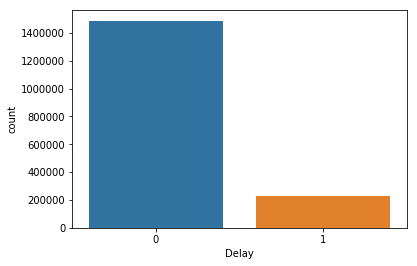

In [17]:
# Bias check
sns.countplot(x="Delay", data=df)

In [0]:
# Check Correlation
def cramers_corrected_stat(x, y):

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

#### Month

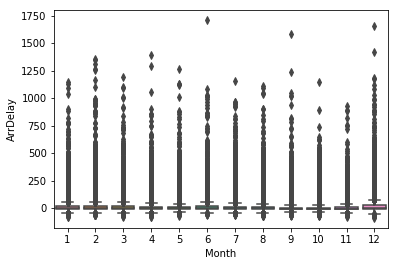

In [19]:
sns.boxplot(x='Month', y='ArrDelay', data=df) #x is feature, y is target

In [20]:
cramers_corrected_stat(df['Delay'], df['Month'])

0.118474

#### DayofMonth

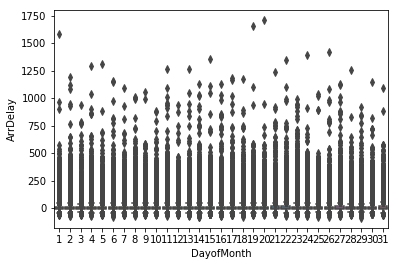

In [21]:
sns.boxplot(x='DayofMonth', y='ArrDelay', data=df) #x is feature, y is target

In [22]:
cramers_corrected_stat(df['Delay'], df['DayofMonth'])

0.034684

#### Weekend

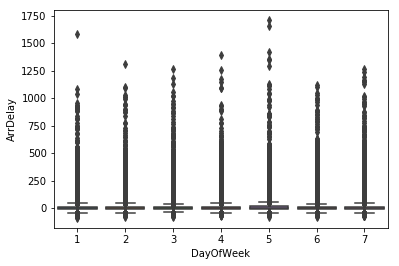

In [23]:
sns.boxplot(x='DayOfWeek', y='ArrDelay', data=df) #x is feature, y is target

In [24]:
cramers_corrected_stat(df['Delay'], df['DayOfWeek'])

0.03572

#### Parts of the Day

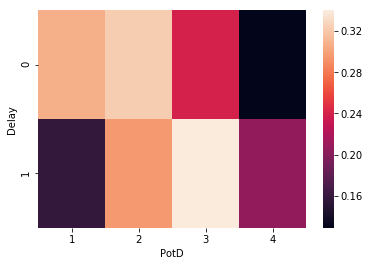

In [25]:
sns.heatmap(pd.crosstab(df['Delay'], df['PotD'], normalize='index'))

In [26]:
cramers_corrected_stat(df['Delay'], df['PotD'])

0.136458

## Model evaluation
We will use F1 score as the evaluation metric. Our target value is binary so it’s a binary classification problem, and out data is inbalance, so in this case F1 score is a good way for evaluation for this type of problems.

In [0]:
# Create a copy of original dataset
df_backup = df.copy()

### Logistic Regression

In [0]:
df = df_backup.copy()

#### One-hot encoding

In [0]:
# Dest column
df = pd.concat([df, pd.get_dummies(df['Dest'], prefix='Dest',dummy_na=True)],axis=1).drop(['Dest'],axis=1)

# UniqueCarrier column
df = pd.concat([df, pd.get_dummies(df['UniqueCarrier'], prefix='UniqueCarrier',dummy_na=True)],axis=1).drop(['UniqueCarrier'],axis=1)

#### Holdout

In [0]:
X_data = df.drop(['Delay', 'ArrDelay'], axis=1)
y_data = df['Delay']

# Holdout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

#### Default setting

In [0]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

#### Hyperparameter tuning

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid = {'C' : [1, 5, 10]}

model_cv = GridSearchCV(estimator = LogisticRegression(), 
                        param_grid = grid, cv = 3, scoring = 'f1', n_jobs = -1)

model_cv.fit(X_data, y_data)

print("tuned hpyerparameters :(best parameters) ",model_cv.best_params_)
print("accuracy :",model_cv.best_score_)

Tune hyper parameters using 3-values-method, with f1 metric.

### Naive Bayes

In [0]:
df = df_backup.copy()

#### Label encoder

In [0]:
from sklearn.preprocessing import LabelEncoder

# Dest column
df['Dest'] = LabelEncoder().fit_transform(df['Dest'])

# UniqueCarrier column
df['UniqueCarrier'] = LabelEncoder().fit_transform(df['UniqueCarrier'])

#### Holdout

In [0]:
X_data = df.drop(['Delay', 'ArrDelay'], axis=1)
y_data = df['Delay']

# Holdout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

#### Default setting

In [31]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92    297699
           1       0.43      0.23      0.30     45014

    accuracy                           0.86    342713
   macro avg       0.66      0.59      0.61    342713
weighted avg       0.83      0.86      0.84    342713



### Random Forest
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

In [0]:
# Default parameters
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs = -1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report


print(classification_report(y_test, y_pred))

#### Hyperparameter tuning

In [0]:
# n_estimators
n_estimators = [1, 5, 10, 15, 20, 25, 50]
test_results = []
for estimator in n_estimators:
    model = RandomForestClassifier(n_estimators = estimator, n_jobs = -1)
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    print(estimator, ' done!')
    
# Plot metrics line chart
sns.lineplot(x = n_estimators, y = test_results)

In [0]:
# max_depths
max_depths = np.linspace(5, 35, 7)
test_results = []

for max_depth in max_depths:
    model = RandomForestClassifier(max_depth = max_depth, n_jobs = -1)
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    print(max_depth, ' done!')

# Plot metrics line chart
sns.lineplot(x = max_depths, y = test_results)

#### Final model
Best parameters:
- n_estimators = 15
- max_depths = 25

In [0]:
model = RandomForestClassifier(n_estimators = 15, max_depth = 25, n_jobs = -1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

### Gradient Boosting
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

#### Default setting

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators = 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

#### Hyperparameter tuning

In [0]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
test_results = []
for learning_rate in learning_rates:
    model = GradientBoostingClassifier(n_estimators = 10, learning_rate = learning_rate)
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    print(learning_rate, ' done!')
    
# Plot metrics line chart
sns.lineplot(x = learning_rates, y = test_results)

In [0]:
# n_estimators
n_estimators = [1, 5, 10, 15, 20, 25, 50]
test_results = []
for estimator in n_estimators:
    model = GradientBoostingClassifier(n_estimators = estimator)
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    print(estimator, ' done!')
    
# Plot metrics line chart
sns.lineplot(x = n_estimators, y = test_results)

In [0]:
# max_depths
max_depths = np.linspace(5, 35, 7)
test_results = []

for max_depth in max_depths:
    model = GradientBoostingClassifier(n_estimators = 10, max_depth = max_depth)
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    print(max_depth, ' done!')

# Plot metrics line chart
sns.lineplot(x = max_depths, y = test_results)

#### Final model
Best parameters:
- learning_rate = 
- n_estimators = 
- max_depths = 

In [0]:
model = GradientBoostingClassifier(learning_rate = , n_estimators = , max_depth = )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

# TODO

1. Edit threshhold / class weight
2. PCA: Dimension reducing
3. RFE: Features selection
4. GridsearchCV for tuning
- Tuning with 3 values
- Goal: Precison ~ Recall (F1 score)
5. Compare performances among models